In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob
from pathlib import Path
#import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

from SEIR.utils import config

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

#@click.command()
#@click.option("-m", "--max_files", type=click.IntRange(min=1), default=1000, help="Maximum number of sims to load")
#@click.option("-f", "--filename", type=str, default=f'{str(datetime.date.today())}_multiplot.pdf',  help="filename to write the pdf in")
#@click.option("-c", "--config", "config_file", envvar="CONFIG_PATH", type=click.Path(exists=True), required=False, help="configuration file for this simulation")

max_files = 25
filename =f'{str(datetime.date.today())}_multiplot.pdf'
config_file = 'config_mod_a.yml'

In [4]:
pdf = PdfPages(filename)
d = pdf.infodict()
d['Title'] = 'Fast report of current runs'
d['Author'] = 'IDDynamics at JHU'

In [3]:
folder = [x for x in Path('hospitalization/model_output/').glob('*') if not x.is_file()]


all_hosp_sim = {}


for fold in folder:
    if ('importation' not in str(fold)):
        data = []
        print(f'loading {str(fold)[13:]} ... ', end = '')
        files_loaded = 0
        for filename in Path(str(fold)).rglob('*.csv'):
            if files_loaded < max_files and 'high' in str(filename):
                sim = pd.read_csv(filename)
                sim = sim.groupby('time').sum()
                sim.drop(['geo_ind', 'date_inds'], axis =1, inplace=True)  # 'geoid'
                
                data.append(sim)
                files_loaded += 1
        for filename in Path(str(fold)).rglob('*.parquet'):
            if files_loaded < max_files and 'high' in str(filename):
                sim = pq.read_table(filename).to_pandas()
                sim = sim.groupby('time').sum()
                sim.drop(['geo_ind', 'date_inds'], axis =1, inplace=True)  # 'geoid' 'sim_num', 'sim_num_good',
                data.append(sim)
                files_loaded += 1

        print(f'... {len(data)} loaded')
        all_hosp_sim [str(fold)[29:]] = data
config.set_file(config_file)
dates = config["report"]["formatting"]["display_dates"].get()
dates.append(str(sim.index[-1]))

loading on/model_output/mid-west-coast-AZ-NV_UKFixed_Pulse ... ... 25 loaded
loading on/model_output/mid-west-coast-AZ-NV_UKFixed_Mild ... ... 25 loaded
loading on/model_output/mid-west-coast-AZ-NV_UKFatigue_Pulse ... ... 25 loaded
loading on/model_output/mid-west-coast-AZ-NV_UKFatigue_Mild ... ... 25 loaded


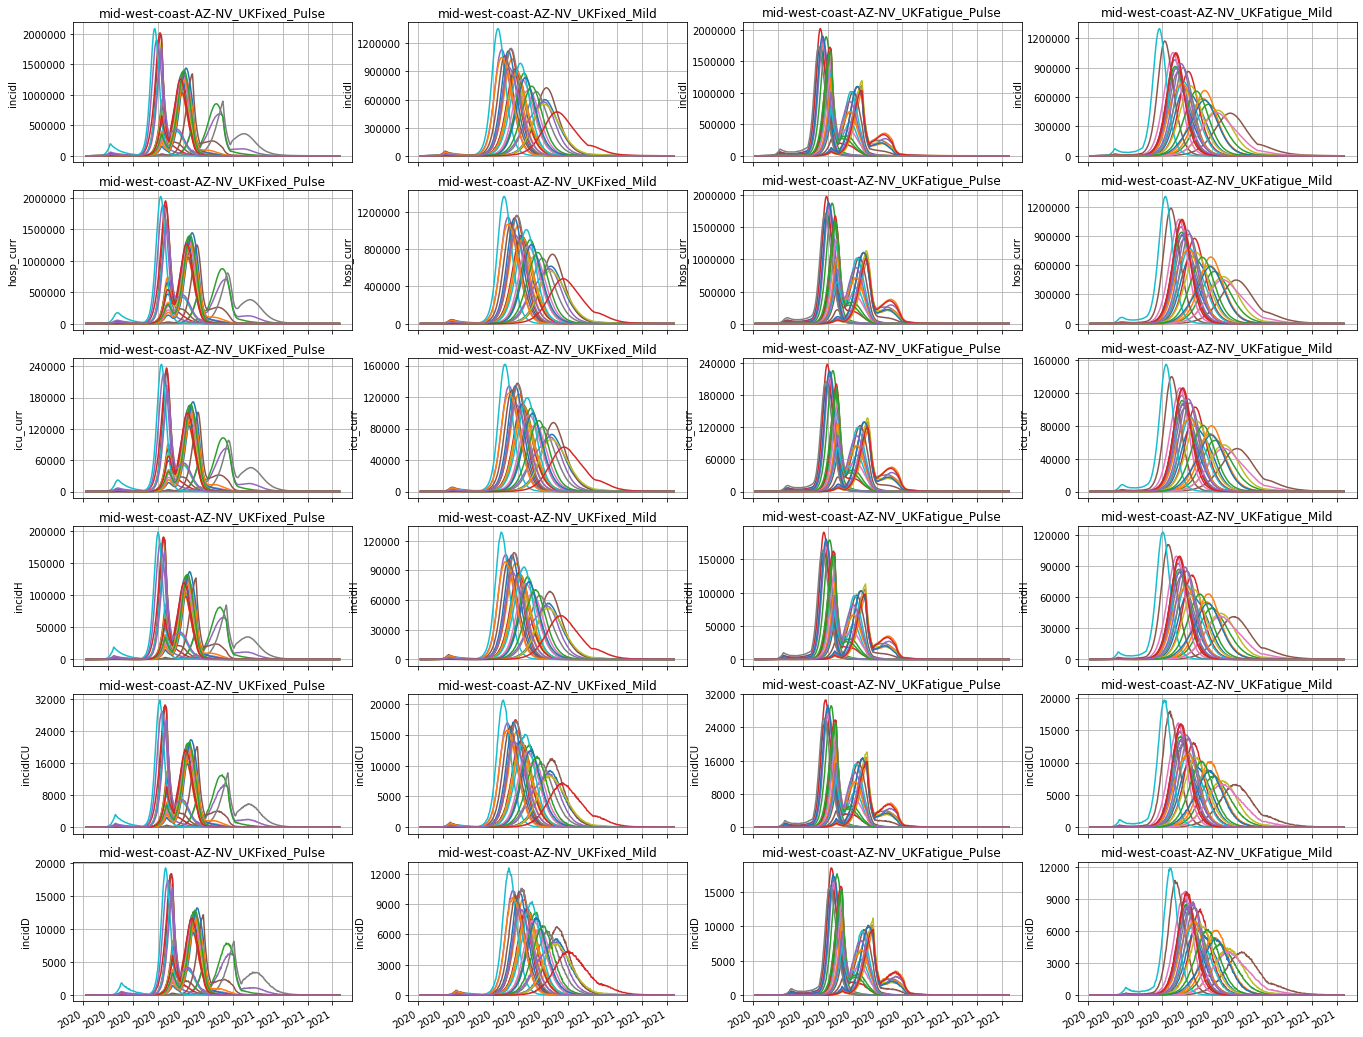

In [4]:
varplot = ['incidI', 'hosp_curr', 'icu_curr', 'incidH','incidICU', 'incidD']

fig, axes = plt.subplots(len(varplot),len(all_hosp_sim), figsize =(23,20), sharex=True)
for vi, var in enumerate(varplot):
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        ax = axes[vi][scn]
        ax.set_title(key)
        ax.xaxis.set_major_locator(plt.MaxNLocator(12))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.grid()
        ax.set_ylabel(var)
        for sim in all_hosp_sim[key]:
            ax.plot(sim[var])
    fig.autofmt_xdate()
pdf.savefig(fig)

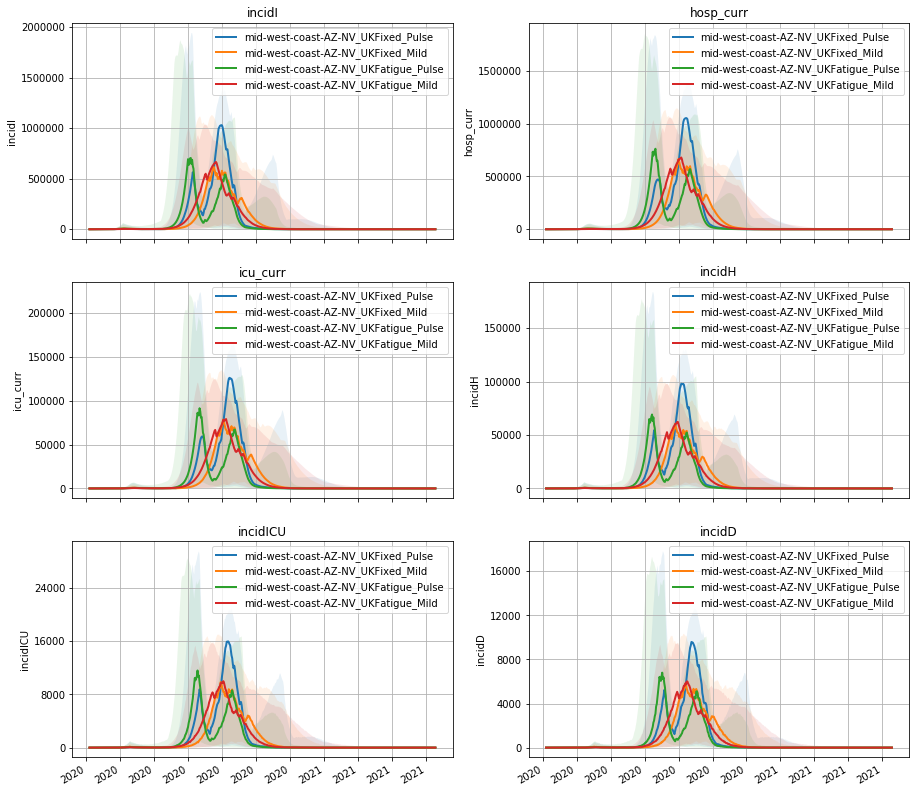

In [6]:
fig, axes = plt.subplots(len(varplot)//2,2, figsize =(15,15), sharex=True)
for vi, var in enumerate(varplot):
    ax = axes.flat[vi]
    ax.set_title(var)
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid()
    ax.set_ylabel(var)
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        sim_of_var = []
        for sim in all_hosp_sim[key]:
            temp = sim[var]
            sim_of_var.append(temp)
        temp = pd.concat(sim_of_var,axis=1)
        
        ax.plot(temp.quantile(.5, axis = 1), label = key,linewidth = 2)
        ax.fill_between(temp.index, temp.quantile(.05, axis = 1), 
                      temp.quantile(.95, axis = 1), alpha =.1)
        ax.legend()
        
    fig.autofmt_xdate()
pdf.savefig(fig)

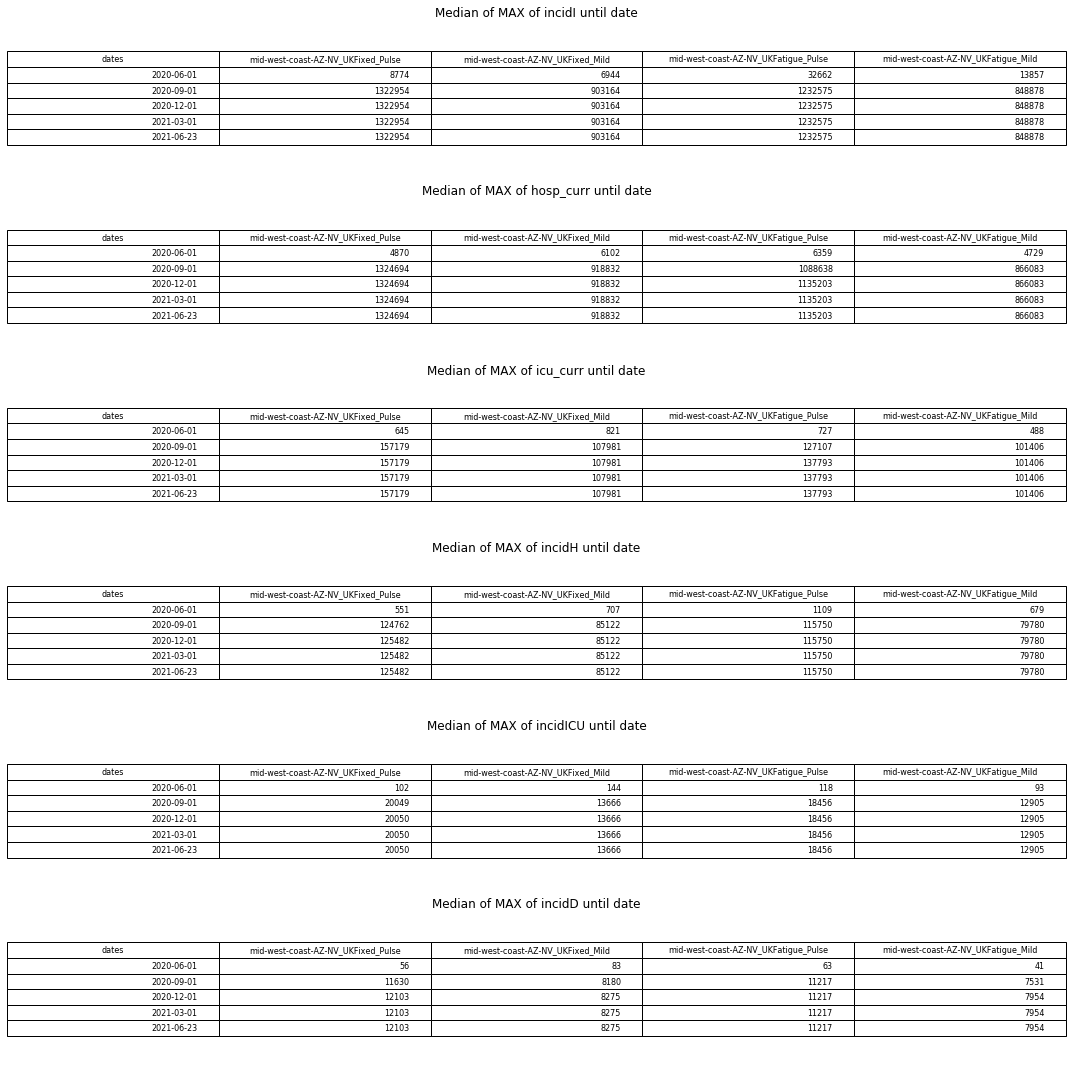

In [7]:
fig, axes = plt.subplots(len(varplot),1, figsize =(15,15))

for i, var in enumerate(varplot):
    ax = axes.flat[i]
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.set_title(f'Median of MAX of {var} until date')
    col = list(all_hosp_sim.keys())
    col.insert(0, 'dates')
    df = pd.DataFrame(0, columns=col, index = dates)
    df['dates'] = dates
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        sim_of_var = []
        for sim in all_hosp_sim[key]:
            temp = sim[var]
            sim_of_var.append(temp)
        temp = pd.concat(sim_of_var,axis=1)
        
        for j, d in enumerate(dates):
            df.iloc[j,scn+1] = int(temp[:datetime.datetime.strptime(d, '%Y-%m-%d').date()].max().quantile(.5))
            
        
    ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()
pdf.savefig(fig)

In [35]:
folder = [x for x in Path('model_output/seir/').glob('*') if not x.is_file()]

all_seir_sim_cumI = {}
all_seir_sim_diffI = {}

for fold in folder:
    if ('importation' not in str(fold)):
        data_cumI = []
        data_diffI = []
        print(f'loading {str(fold)[13:]} ... ', end = '')
        files_loaded = 0
                
        for filename in Path(str(fold)).rglob('*.parquet'):
            if files_loaded < max_files:
                sim = pq.read_table(filename).to_pandas()
                sim_c = sim[sim['comp']=='cumI']
                sim_c.drop('comp', axis =1, inplace=True)
                sim_c.set_index('time', inplace = True)
                sim_c = sim_c.sum(axis = 1)
                
                sim_d = sim[sim['comp']=='diffI']
                sim_d.drop('comp', axis =1, inplace=True)
                sim_d.set_index('time', inplace = True)
                sim_d = sim_d.sum(axis = 1)
                
                data_cumI.append(sim_c)
                data_diffI.append(sim_d)
                files_loaded += 1

        data_cumI = pd.concat(data_cumI,axis=1)
        print(f'... {len(data_cumI.columns)} loaded')
        data_diffI = pd.concat(data_diffI,axis=1)
        all_seir_sim_cumI[str(fold)[13:]] = data_cumI
        all_seir_sim_diffI[str(fold)[13:]] = data_diffI

loading seir/California ... 

/Users/chadi/opt/miniconda3/envs/covidSP/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


... 21 loaded


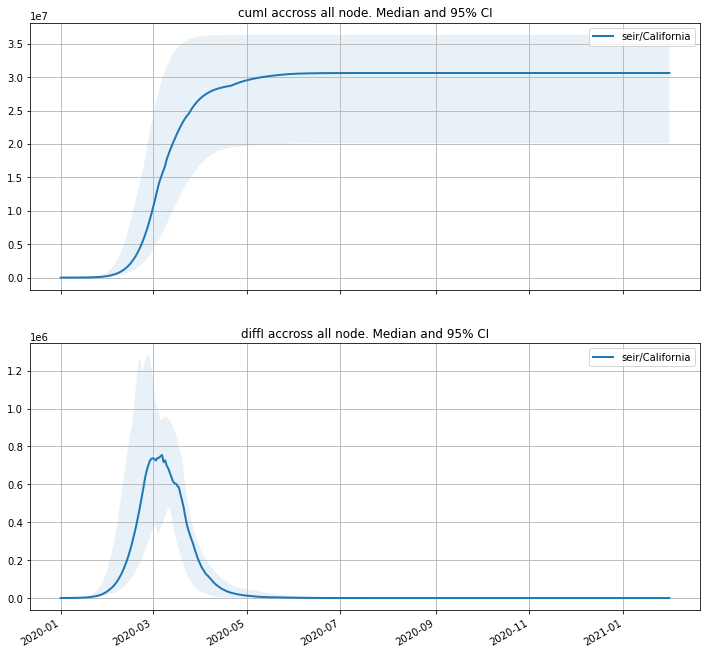

In [36]:
fig, axes = plt.subplots(2,1, figsize =(12,12), sharex=True)


for key, value in all_seir_sim_cumI.items():
    
    axes[0].plot(value.quantile(.5, axis = 1), label = key, linewidth = 2)
    axes[0].fill_between(value.index, value.quantile(.05, axis = 1), 
                      value.quantile(.95, axis = 1), alpha =.1 )

axes[0].legend()
axes[0].grid()
axes[0].set_title(f'cumI accross all node. Median and 95% CI')

for key, value in all_seir_sim_diffI.items():
    axes[1].plot(value.quantile(.5, axis = 1), label = key, linewidth = 2)
    axes[1].fill_between(value.index, value.quantile(.05, axis = 1), 
                      value.quantile(.95, axis = 1), alpha =.1 )

axes[1].legend()
axes[1].grid()
axes[1].set_title(f'diffI accross all node. Median and 95% CI')
fig.autofmt_xdate()
pdf.savefig(fig)

In [2]:
fig, axes = plt.subplots(len(all_seir_sim_cumI),1, figsize =(15,15), sharex=True)
i=0
for key, value in all_seir_sim_cumI.items():
    axes.flat[i]
    #fig, axes = plt.subplots(1,1, figsize =(10,5))
    ax = value.max().hist(ax= axes.flat[i])
    axes.flat[i].set_title(f"Final Size {key}")
    i=i+1
pdf.savefig(fig)

NameError: name 'value' is not defined

In [11]:
#sim = pq.read_table(filename).to_pandas()
#sim = sim[sim['comp']==comp]
#sim.drop('comp', axis =1, inplace=True)
#sim.set_index('time', inplace = True)
#sim.plot( legend = False)
#all_sim[list(all_sim.keys())[0]][0].plot()

In [13]:
pdf.close()